In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,f1_score,classification_report
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2

In [2]:
df=pd.read_csv(r"C:\Users\tareq\Desktop\All_Users_Labeled.csv")

In [109]:
df.head()

,Full_Text,total_words,total_char,avg_chr_per_word,total_emojis,o,c,e,a,n
0,كلمه انثي صارت تضرب عصبي بمناسبه المراه العالم...,2530.0,17071.0,6.087708,151.0,0,0,1,1,0
1,فش موظفين القهوه الكيوت اللي بحكيلك بنفع يحط ش...,1394.0,8593.0,5.656274,28.0,1,0,0,0,0
2,مباشر القداس الالهي وصلاه المراثي كنيسه القديس...,5404.0,38315.0,6.158481,2.0,0,1,0,1,0
3,ارتفع قهوه ارتفع قلبين قطعه شوكولاته ارتفع قل...,674.0,4665.0,6.584828,48.0,1,0,0,0,0
4,يتدحرج الارض الضحك فن غيم غيم وجه متعب ...,328.0,2398.0,6.471875,47.0,1,0,1,0,0


In [10]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
df[['total_words','total_char','avg_chr_per_word','total_emojis']]=ss.fit_transform(df[['total_words','total_char','avg_chr_per_word','total_emojis']])

C:\Users\tareq\AppData\Local\Temp\ipykernel_3488\3509394340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['total_words','total_char','avg_chr_per_word','total_emojis']]=ss.fit_transform(df[['total_words','total_char','avg_chr_per_word','total_emojis']])


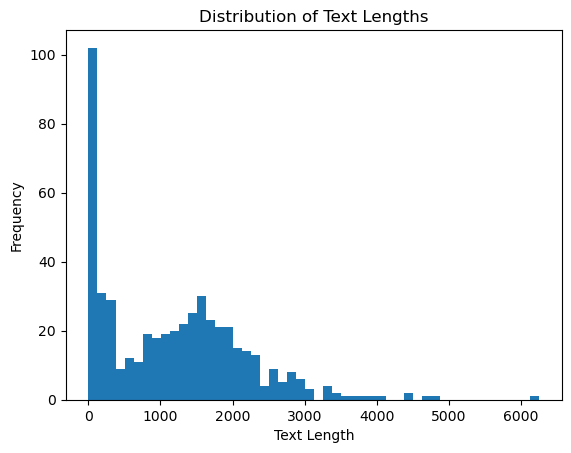

In [11]:
import matplotlib.pyplot as plt

# Compute the length of each text in the dataset
text_lengths = [len(text.split()) for text in df['Full_Text']]

# Plot the distribution of text lengths
plt.hist(text_lengths, bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [90]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Concatenate,Dropout,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam


X = df['Full_Text']
#y = df[['o', 'c', 'e', 'a', 'n']]
y=df['n']
other_features = df[['total_words', 'total_char', 'avg_chr_per_word', 'total_emojis']]

X_train, X_test, y_train, y_test, other_features_train, other_features_test = train_test_split(X, y, other_features, test_size=0.2, random_state=42)

# Tokenize the input texts
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=95000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the input sequences
max_len = 2000 # Set a max length that captures most of the context without introducing too much padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to categorical format
#y_train_cat = to_categorical(y_train)
#y_test_cat = to_categorical(y_test)

# Define the other features input layer
other_features_input = Input(shape=(4,), name='other_features_input')

# Define the text input layer
text_input = Input(shape=(max_len,), name='text_input')

# Define the embedding layer for the text input
embedding_dim = 64
embedded_text = Embedding(input_dim=95000, output_dim=embedding_dim, input_length=max_len)(text_input)

# Define the LSTM layer
lstm = LSTM(units=8)(embedded_text)
# Add Dense layer to reshape input_features
dense = Dense(units=8)(other_features_input)

# Concatenate the LSTM output and dense layer output
concatenated = Concatenate()([lstm, dense])

# Define the output layer

output = Dense(units=1, activation='sigmoid')(concatenated)

# Define the model with both the text input and other features input
model = Model(inputs=[text_input, other_features_input], outputs=output)

# compute class weights
total = y.shape[0]
class_0 = np.sum(y == 0)
class_1 = np.sum(y == 1)
w0 = total / class_0
w1 = total / class_1
class_weight = {0: w0, 1: w1}

# Compile the model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = "binary_crossentropy", optimizer = opt,metrics=['accuracy'])

# Train the model
es = EarlyStopping(patience=3, verbose=1)
history = model.fit(
    x=[X_train_padded, other_features_train],
    y=y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    #shuffle=True,
    #class_weight=class_weight,
    callbacks=[es]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x=[X_test_padded, other_features_test], y=y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')


Epoch 1/20
11/11 [==============================] - 14s 1s/step - loss: 0.6028 - accuracy: 0.7090 - val_loss: 0.4841 - val_accuracy: 0.8025
Epoch 2/20
11/11 [==============================] - 11s 956ms/step - loss: 0.5558 - accuracy: 0.7554 - val_loss: 0.4925 - val_accuracy: 0.8025
Epoch 3/20
11/11 [==============================] - 11s 1s/step - loss: 0.5380 - accuracy: 0.7616 - val_loss: 0.4864 - val_accuracy: 0.8025
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 0.5480 - accuracy: 0.7616 - val_loss: 0.4936 - val_accuracy: 0.8025
Epoch 4: early stopping
4/4 [==============================] - 1s 183ms/step - loss: 0.5924 - accuracy: 0.7624
Test Loss: 0.5924325585365295, Test Accuracy: 0.7623762488365173


In [98]:
model.save('saved_model/rnn_n_33')

INFO:tensorflow:Assets written to: saved_model/rnn_n_33\assets


INFO:tensorflow:Assets written to: saved_model/rnn_n_33\assets


In [97]:
y_pred=model.predict(x=[X_test_padded, other_features_test])
sum(y_pred>0.33)

4/4 [==============================] - 1s 140ms/step


array([22])

In [92]:
sum(y_test)

23

In [10]:
X_num = df.iloc[:, 1:5].values

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.metrics import precision_score, recall_score

# Extract the numerical features and labels
X_num = df.iloc[:, 1:5].values
#ss=StandardScaler()
#X_num=ss.fit_transform(X=X_num)
y = df['c'].values

# Convert the cleaned text to numerical features using BoW
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df['Full_Text'])

In [79]:
dfdf=pd.DataFrame(X_text.toarray(),columns=vectorizer.get_feature_names_out())
dfdf['total_words']= [x[0] for x in X_num]
dfdf[ "total_char"]= [x[1] for x in X_num]
dfdf["avg_chr_per_word"]= [x[2] for x in X_num]
dfdf["total_emojis"]= [x[3] for x in X_num]
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dfdf, y, test_size=0.2, random_state=42)

In [80]:
# Instantiate an RFC model
rfc = RandomForestClassifier(random_state=42)

# Train the model
rfc.fit(X_train, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.5742574257425742
Precision: 0.18181818181818182
Recall: 0.05555555555555555


In [81]:
#rfc
#oversampling

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')

Train accuracy: 1.0000
Test accuracy: 0.4851
Precision: 0.2333
recall: 0.1944


In [82]:
#rfc
#oversampling


# Use SMOTE to oversample the minority class
smote = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')

Train accuracy: 1.0000
Test accuracy: 0.5347
Precision: 0.2609
recall: 0.1667


In [84]:
#rfc
#undersamping

# Use Random Undersampling to undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train the model
rfc = RandomForestClassifier()
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')


Train accuracy: 1.0000
Test accuracy: 0.4158
Precision: 0.3051
recall: 0.5000


In [ ]:
rfc : recall 58

In [ ]:
while(recall_score(y_test, y_pred)<0.56):
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
recall_score(y_test, y_pred)

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74        65
           1       0.22      0.06      0.09        36

    accuracy                           0.59       101
   macro avg       0.43      0.47      0.41       101
weighted avg       0.48      0.59      0.51       101



In [77]:
import joblib
joblib.dump(rfc, 'O_recall_58.pkl')

['O_recall_58.pkl']

In [ ]:
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')

In [179]:
#rfc
#oversampling+undersampling(smote)

# Use SMOTE to oversample the minority class and Random Undersampling to undersample the majority class
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')


Train accuracy: 0.6536
Test accuracy: 0.6040
Precision: 0.4444
recall: 0.4444


In [64]:
#rfc
#oversampling+undersampling(random)


# Use SMOTE to oversample the minority class and Random Undersampling to undersample the majority class
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')


Train accuracy: 1.0000
Test accuracy: 0.6832
Precision: 0.6250
recall: 0.2778


In [201]:
# Define a pipeline that consists of Kernel PCA and RFC
pipe = make_pipeline(
    RandomForestClassifier(random_state=42)
)

# Define the hyperparameters to search over
param_grid = {
    'randomforestclassifier__n_estimators': [75, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 15],
    'randomforestclassifier__max_features': ['auto','sqrt', 'log2'],
}

# Instantiate GridSearchCV
scorer = make_scorer(recall_score)

grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Extract the best set of hyperparameters and the corresponding accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [203]:
best_score

0.9248977206312098

In [206]:
grid_search.

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [199]:

# Train the model
rfc = RandomForestClassifier(random_state=42,n_estimators=best_params['randomforestclassifier__n_estimators'],max_depth=best_params['randomforestclassifier__max_depth'],max_features=best_params['randomforestclassifier__max_features'])
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')

Train accuracy: 0.8720
Test accuracy: 0.6733
Precision: 0.5517
recall: 0.4444


In [200]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76        65
           1       0.55      0.44      0.49        36

    accuracy                           0.67       101
   macro avg       0.64      0.62      0.63       101
weighted avg       0.66      0.67      0.66       101



In [77]:

# Use SMOTE to oversample the minority class and Random Undersampling to undersample the majority class
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Use PCA
pca=LatentDirichletAllocation(500,random_state=42)
X_train_resampled=pca.fit_transform(X_train_resampled)
X_test=pca.transform(X_test)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_accuracy = rfc.score(X_train_resampled, y_train_resampled)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
print(f'recall: {recall:.4f}')

Train accuracy: 0.9895
Test accuracy: 0.6765
Precision: 0.0000
recall: 0.0000


In [150]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(df['tweets_text'], df['o'], test_size=0.2)
# Tokenize the tweets_text column
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Define a pipeline that consists of Kernel PCA and RFC
pipe = make_pipeline(
    KernelPCA(),
    RandomForestClassifier(random_state=42)
)

# Define the hyperparameters to search over
param_grid = {
    'kernelpca__kernel': ['rbf'],
    'kernelpca__n_components': [500],
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
}

# Instantiate GridSearchCV
scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Extract the best set of hyperparameters and the corresponding accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [87]:
#rfc
#pca

# Apply PCA for dimensionality reduction
kpca = KernelPCA(n_components=500)
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

# Train the model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# Evaluate the model
train_accuracy = rfc.score(X_train, y_train)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

Train accuracy: 1.0000
Test accuracy: 0.4455
Precision: 0.2368


In [88]:
#rfc
#pca

# Apply PCA for dimensionality reduction
kpca = KernelPCA(n_components=500, kernel='rbf')
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

# Train the model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the model
train_accuracy = rfc.score(X_train, y_train)
test_accuracy = rfc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Compute precision on the test set
y_pred = rfc.predict(X_test)
precision = recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

Train accuracy: 1.0000
Test accuracy: 0.6535
Precision: 0.0278


In [164]:
#RNN


# Tokenize the tweets_text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweets_text'])
X = tokenizer.texts_to_sequences(df['tweets_text'])
X = pad_sequences(X)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df[['o', 'c', 'e', 'a', 'n']], test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)



In [ ]:
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=X.shape[1]))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print(f'Validation accuracy: {accuracy:.4f}')

# Test the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f'Test accuracy: {accuracy:.4f}')


Epoch 1/10
 9/12 [=====================>........] - ETA: 14:13 - loss: 0.6881 - accuracy: 0.2396